**Exercise 2.5 from Sutton, Richard S. ; Barto, Andrew G.: *Reinforcement Learning: An Introduction (pg52)***

*Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the q(a) start out equal and then take independent random walks. Prepare plots like Figure 2.1 for an action-value method using sample averages, incrementally computed by α = 1/k, and another action-value method using a constant step-size parameter, α = 0.1. Use ε = 0.1 and, if necessary, runs longer than 1000 plays.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# Define the random walk
def RandomWalk(x):
    '''
    x is a vector, each element takes a random walk independently
    This function return a new vector where each element takes a step by the rule of random walk'''
    
    dim=np.size(x)
    walk_set=[-1,1,0]
    for i in range(dim):
        x[i]=x[i]+np.random.choice(walk_set)
    
    return x

In [3]:
def epsilon_greedy(x, epsilon, arms):
    '''
    x is a vector holding value estimates for each action a at the timestep
    epsilon is the probability with which the agent doesn't select the greedy action
    arms are the number of actions teh bandit could select
    This function returns the column index to select
    '''
    
    r = random.uniform(0,1)
    i = np.argmax(x) # find index of highest value action
    column_indexes = list(range(0,arms))
    
    # Choose a random action (not the max) if we fall into epsilon
    if r <= epsilon:
        column_indexes.remove(i)
        i = random.choice(column_indexes) # choose a random action index
        return i
    
    # Choose greedily if we don't fall into epsilon
    else:
        return i    

In [6]:
def multi_task(epsilon=0.1, max_iter=10000, tasks=500, arms=10, alpha=0.1):
    '''
    epsilon = the probability te agent doesn't selection a greedy action
    max_iter = the number of steps taken by the value function in the random walk
    tasks = the number of random bandits we will average across
    arms = the number of actions a bandit can take at each step
    alpha = the constant stepsize parameter used to calcuate new reward estimates
    
    This function returns two vectors (constR and variabR) that quanitfy the average reward
    achieved across 500 bandits based on reward estimated via constant/variable stepsizes
    at each timestep
    '''
    
    rows, cols = tasks, arms
    
    # create true value of arms with random walk
    q = np.array( [([0]*arms) for i in range(rows)] ) 
    constQ = np.array( [([0]*cols) for i in range(rows)] )
    variabQ = np.array( [([0]*cols) for i in range(rows)] )
    constN = np.array( [([0]*cols) for i in range(rows)] )
    variabN = np.array( [([0]*cols) for i in range(rows)] )
    constR = np.zeros(max_iter)
    variabR = np.zeros(max_iter)
    
    # iteration loop (within each iteration we have a random number of bandits (tasks) that we will average over)
    for i in range(max_iter):
        
        # task loop (the random bandits we cycle through per each iteration)
        for j in range(tasks):
            # random walk of each arm
            task_q = q[j, :]
            task_q = RandomWalk(task_q)
            q[j,:] = task_q
        
            # CONSTANT STEPSIZE
            
            # get one random arm from set of tasks
            task_constQ = constQ[j,:]
            task_constN = constN[j,:]
            
            # find the arm to pick
            action_index_c = epsilon_greedy(task_constQ, epsilon, arms)
            
            # get reward
            reward_const = q[j,action_index_c]
            
            # add reward to total rewards for this iteration (to be averaged later)
            constR[i] = constR[i] + reward_const
            
            # update estimated value of arm based on observation
            task_constQ[action_index_c] = task_constQ[action_index_c] + alpha*(reward_const-task_constQ[action_index_c])
            constQ[j,:] = task_constQ
            
            # update number of times arm has been selected
            task_constN[action_index_c] = task_constN[action_index_c] + 1
            constN[j:] = task_constN
            
            # VARYING STEPSIZE
            
            # get one arm from set of tasks
            task_variabQ = variabQ[j,:]
            task_variabN = variabN[j,:]
            
            # find arm to pick
            action_index_v = epsilon_greedy(task_variabQ, epsilon, arms)
            
            # get reward from true values of arms
            reward_variab = q[j,action_index_v]
            
            # add reward to total rewards for this iteration
            variabR[i] = variabR[i] + reward_variab
            
            # update number of times arm has been selected
            task_variabN[action_index_v] = task_variabN[action_index_v] + 1
            variabN[j,:] = task_variabN
            
            # set stepsize to 1 for first iteration
            if i == 0:
                beta = 1
            else:
                beta = (1/task_variabN[action_index_v])
            
            # update estimated value of action based on observation 
            task_variabQ[action_index_v] = task_variabQ[action_index_v] +\
                                           beta*(reward_variab-task_variabQ[action_index_v])
            variabQ[j,:] = task_variabQ
        
        # get average reward across all bandits for each iteration
        constR[i] = constR[i] / tasks
        variabR [i] = variabR[i] / tasks
        
    return constR, variabR
        

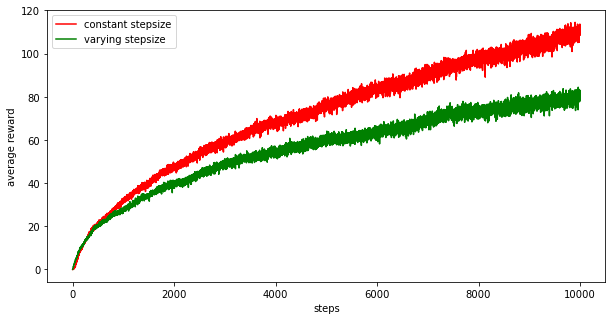

In [9]:
# calculate and plot
R_c_step, R_v_step = multi_task()

fig = plt.figure(figsize=(10,5))
fig.add_subplot(111)
plt.xlabel('steps')
plt.ylabel('average reward')
plt.plot(R_c_step, 'r', label='constant stepsize')
plt.plot(R_v_step, 'g', label='varying stepsize')
plt.legend(loc='upper left')
plt.savefig('../../notes/images/ex2.5.png', dpi=300)
plt.show()

After 10000 steps of the value function, each following a random walk so as to make this problem non-stationary, the algorithm with constant stepsize has performed slighlty better than that with varying stepsize. To be clear, the constant stepsize updating formula is of the form:

$Q_k+1 = Q_k + \alpha[R_k - Q_k]$

This means that recent updates to the our estimate of the an arm's value are weighted more heavily than those in the past (a recency weighted average) , ideal for a problem where the values are non-stationary. In contrast, the varying stepsize algorithm weights all rewards equally, and demostrably does a worse job tracking the non-staionary values of the bandit arms.